In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from skimage import filters
import numpy as np
import cv2
import pandas as pd
from scipy import ndimage as nd
import pickle
from skimage.filters import roberts, sobel, scharr, prewitt
from matplotlib import pyplot as plt
import os
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def remove_background(img,num):    
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img

In [ ]:
def cleanData(data):
  for i in data.columns:
    (unique, counts) = np.unique(data[i], return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    if len(unique)== 2: 
      zero = counts[0]
      one = counts[1]
      proportion = one/(zero+one)
      if proportion<0.05 or proportion>0.95: # one percent
        data = data.drop([i], axis=1) # we assume the feature is not giving enough information --> will remove this feature
    if len(unique)==1:
        data=data.drop([i], axis=1) # we assume the feature is not giving enough information --> will remove this feature
  return data
  
def calc_weights_class():
  classes = [0,1]
  cw = compute_class_weight('balanced', classes, Y) # If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))
  return cw


def remove_less_significant_features(X,feature_importance, names):
    sl = 0.005
    columns_dropped = np.array([])
    for i in range(len(feature_importance.values)): 
        val=feature_importance[0][i]
        col = names[0][i]
        if val < sl and val>0 or val>sl and val<0 :
            X.drop(col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [col])
    print("col droped: ",columns_dropped )
    return X


def remove_by_featureImp(model,X,Y):
    feature_importance = model.feature_importances_
    feat_imp=pd.DataFrame(feature_importance) 
    names=pd.DataFrame(X.columns)
    X_new=remove_less_significant_features(X,feat_imp,names)
    dataset = pd.concat([X_new, Y], axis=1)
    return dataset

In [ ]:
def plot_feature_importance(importance,names,model_type):
  feature_importance = np.array(importance)
  feature_names = np.array(names)
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  plt.figure(figsize=(10,8))
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

In [ ]:
def feature_extraction(temp, img,src):
    df = pd.DataFrame()
    img2 = img.reshape(-1)
    df = pd.DataFrame()
    df['Original Image'] = img2
   
    red_channel = src[:,:,2]
    green_channel = src[:,:,1]
    blue_channel = src[:,:,0]
    df['red*green']=(red_channel.reshape(-1))*green_channel.reshape(-1)
    df['blue*green']=(blue_channel.reshape(-1))*green_channel.reshape(-1)
    df['red*blue']=(red_channel.reshape(-1))*blue_channel.reshape(-1)

    df['red'] = red_channel.reshape(-1)
    df['green'] = green_channel.reshape(-1)
    df['blue'] = blue_channel.reshape(-1)

    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values   
    
    # Generate Gabor features # https://en.wikipedia.org/wiki/Gabor_filter#:~:text=In%20image%20processing%2C%20a%20Gabor,point%20or%20region%20of%20analysis.
    num = 1  # To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    theta = 0
    for theta in range(2): 
        theta += theta / 4 
        for sigma in range(10, 45, 5):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.45, 0.05):
                    gabor_label = 'Gabor' + str(num)  
                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img 
                    temp['gabor_label'].append(gabor_label)
                    temp['theta'].append(theta)
                    temp['sigma'].append(sigma)
                    temp['lamda'].append(lamda)
                    temp['gamma'].append(gamma)
                    num += 1 
    return temp


    # CANNY EDGE
    edges = cv2.Canny(img, 100,200)  
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1 

    # ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    # SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    # SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1

    # PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    # GAUSSIAN with sigma = 3
    from scipy import ndimage as nd
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1

    # GAUSSIAN with sigma = 7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3

    # MEDIAN 
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    
    
    # VARIANCE 
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1 

    return df

In [ ]:
import math
def preformance_measures(groundtruth_list, predicted_list):
    TN, FP, FN, TP = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
    print("Semantic segmentation measures")
    print("Pixel accuracy = ",sklearn.metrics.accuracy_score(groundtruth_list, predicted_list))
    print("IoU = ",TP/(TP+FP+FN))

    print("Imbalanced dataset measures")
    print("MCC = ",sklearn.metrics.matthews_corrcoef(groundtruth_list, predicted_list))
    print("F1 score = ",sklearn.metrics.f1_score(groundtruth_list, predicted_list,average='weighted'))
    print("Weighted TPR − TNR = ",(0.05*(TP/(TP+FN))+0.95*(TN/(TN+FP))))
    print("Geometric mean = ", math.sqrt((TP/(TP+FN))*(TN/(TN+FP))))
    print("TPR = ", TP/(TP+FN)) 
    print("FPR = ", FN/(TP+FN)) 
    print("recall = ",sklearn.metrics.recall_score(groundtruth_list, predicted_list))
    FPR, TPR, _ = sklearn.metrics.roc_curve(groundtruth_list, predicted_list)
    print("AUC of ROC Curve = ", sklearn.metrics.roc_auc_score(groundtruth_list, predicted_list,average='weighted'))
    plt.plot(FPR, TPR)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()     
          
    cf_matrix = confusion_matrix(y_true = groundtruth_list,y_pred = predicted_list)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
image_dataset = pd.DataFrame()  
img_path = r'/content/drive/MyDrive/Colab Notebooks/tesis/all_images/'

for image in sorted(os.listdir(img_path)):
    if image.endswith('.json'):
      continue
    else:  
      print(image) 
      df = pd.DataFrame() 
      input_img = cv2.imread(img_path + image)  
      input_img = cv2.resize(input_img, (244,244))
      img = remove_background(input_img,1)

image_dataset=cleanData(image_dataset)



In [ ]:
mask_dataset = pd.DataFrame() 

mask_path = r'/content/drive/MyDrive/Colab Notebooks/segmentation/Branch/ground_truth/skeleton/'  
mask_list = sorted(os.listdir(mask_path))  
for mask in mask_list:  
    print(mask)
    
    df2 = pd.DataFrame()  
    input_mask = cv2.imread(mask_path + mask)
    input_mask = cv2.resize(input_mask, (244,244), interpolation =cv2.INTER_NEAREST)
    label = cv2.cvtColor(input_mask,cv2.COLOR_BGR2GRAY)
    df2['Label_Value'] = label.reshape(-1)

    mask_dataset = mask_dataset.append(df2)

In [ ]:
dataset = pd.concat([image_dataset, mask_dataset], axis=1)

import pickle

filename = "data"
pickle.dump(dataset, open(filename, 'wb'))

print("done")    

done


In [ ]:
dataset=pickle.load(open("data", 'rb'))
dataset=pd.DataFrame(dataset)
dataset=dataset.drop_duplicates(subset=None, keep='first', inplace=False)

X = pd.DataFrame(dataset.drop(labels = ["Label_Value"], axis=1)) 

 
scale = sklearn.preprocessing.StandardScaler()
X = pd.DataFrame(scale.fit_transform(X))

Y = pd.DataFrame(dataset["Label_Value"].values /255)

from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

X_train.shape

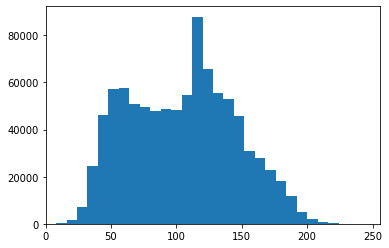

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

fig, ax = plt.subplots(1, 1)
ax.hist(input_img.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


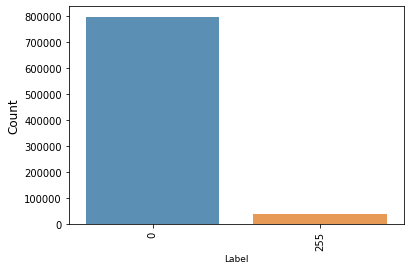

In [ ]:
value_counts = dataset['Label_Value'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(value_counts.index, value_counts.values, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Label', fontsize=9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
import seaborn as sns
sns.set_style("white")
for i in dataset.columns:
  x1 = dataset.loc[dataset["Label_Value"] == 0, i]
  x2 = dataset.loc[dataset["Label_Value"] == 255, i]

  # Plot
  kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

  plt.figure(figsize=(10,7), dpi= 80)
  sns.distplot(x1, color="dodgerblue", label="0", **kwargs)
  sns.distplot(x2, color="orange", label="1", **kwargs)
  plt.legend();

### Random Forest
    

[ 0.52359553 11.09522722]
Semantic segmentation measures
Pixel accuracy =  0.8149831456254274
IoU =  0.1478900719103629
Imbalanced dataset measures
MCC =  0.27346692685898716
F1 score =  0.8655562962024537
Weighted TPR − TNR =  0.8144569886813395
Geometric mean =  0.7633522153498471
TPR =  0.7106884543262791
FPR =  0.28931154567372086
AUC of ROC Curve =  0.7653034724078898


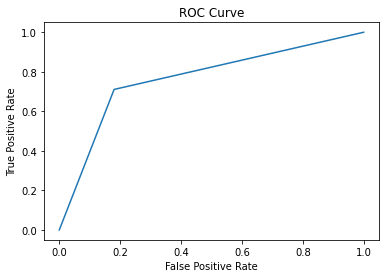

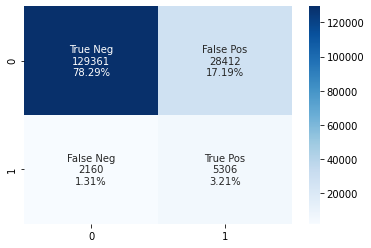

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cw = calc_weights_class() # tree class's weights 
print(cw)
model = RandomForestClassifier(n_estimators = 100,criterion='gini',max_depth=8, random_state = 42,class_weight={0: cw[0], 1: cw[1]},verbose=2)
model=model.fit(X_train,y_train)
predicted_list=model.predict(X_test)
preformance_measures(y_test, predicted_list)

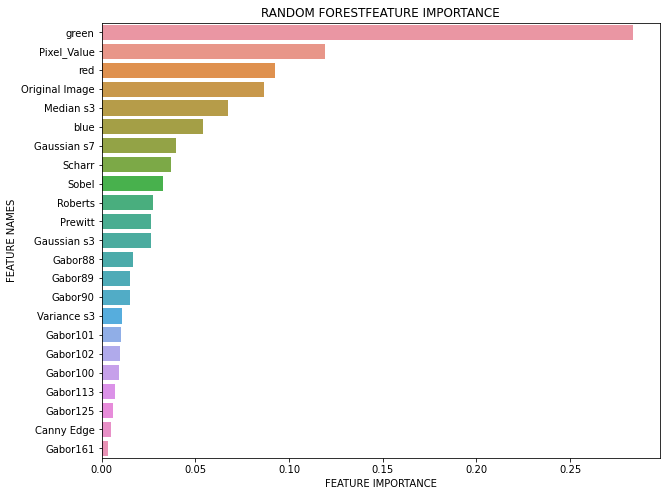

In [ ]:
plot_feature_importance(model.feature_importances_,X.columns,'RANDOM FOREST')

In [ ]:
X = pd.DataFrame(dataset.drop(labels = ["Label_Value"], axis=1)) 
Y_new=pd.DataFrame(dataset["Label_Value"].values /255)
new_data=remove_by_featureImp(model,X,Y_new)

In [ ]:
# SVM
X_new = pd.DataFrame(dataset.drop(labels = ['Gabor16', 'Gabor17', 'Gabor18', 'Gabor28','Gabor29', 'Gabor30' ,'Gabor40','Label_Value' ,'Gabor41' ,'Gabor42', 'Gabor52', 'Gabor53' ,'Gabor54', 'Gabor64', 'Gabor65','Gabor66', 'Gabor76', 'Gabor77', 'Gabor78', 'Gabor104' ,'Gabor136', 'Gabor138', 'Gabor148' ,'Gabor150'], axis=1)) 
X_train, X_test, y_train, y_test = train_test_split(X_new,Y, test_size=0.2, random_state=20)


In [ ]:
predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

In [ ]:
import math

cw = calc_weights_class() # tree class's weights 

param_grid = { 
    'n_estimators': [200,300],
    'max_depth' : [8,14],
    'criterion' :['gini', 'entropy']
}
# Create a based model
rf=RandomForestClassifier(random_state=42,class_weight={0: cw[0], 1: cw[1]})
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,verbose=3, param_grid = param_grid,scoring='roc_auc_ovo_weighted',cv=5)# cv=10 for cross validation tunning
# fit it 
grid_search.fit(X_train, y_train)
# best parms
grid_search.best_params_
# best estimator 
best_grid = grid_search.best_estimator_

results_df = pd.DataFrame(grid_search.cv_results_)

# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")


predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

### SVM


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# cw = calc_weights_class() # tree class's weights 
param_grid = { 
    'C' : [10,15,20,50],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm.SVC(kernel='linear',C=10, class_weight='balanced',max_iter=1500), param_grid = param_grid,scoring='accuracy',cv=5,verbose=3)
grid_search.fit(X_train, y_train)

# best parms
grid_search.best_params_
# best estimator 
best_grid = grid_search.best_estimator_

# evaluation
results_df = pd.DataFrame(grid_search.cv_results_)

# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")


predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm

cw = calc_weights_class() # tree class's weights 

model = LinearSVC(C=10, class_weight={0: 0.5, 1: 11}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=2)
model=model.fit(X_train,y_train)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
predicted_list=model.predict(X_test)
preformance_measures(y_test, predicted_list)
plot_feature_importance(model.feature_importances_,X.columns,'LINEAR SVM')


In [ ]:
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
features_names=X.columns
svm = svm.SVC(kernel='linear',C=10, class_weight={0: 0.5, 1: 11},max_iter=1500,verbose=3)
svm.fit(X_train,y_train)
f_importances(svm.coef_[0], features_names)
predicted_list=svm.predict(X_test)
preformance_measures(y_test, predicted_list)

In [ ]:
def remove_less_significant_features(X,feature_importance, names):
    sl = 0.1
    columns_dropped = np.array([])
    for i in range(len(feature_importance.values)): 
        val=feature_importance[0][i]
        col = names[0][i]
        if val < sl and val>0 or val>sl and val<0 :
            X.drop(col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [col])
    print("col droped: ",columns_dropped )
    return X

remove_less_significant_features(X,pd.DataFrame(svm.coef_[0]),pd.DataFrame(X.columns))

In [ ]:
predicted_list=svm.predict(X_test)
preformance_measures(y_test, predicted_list)

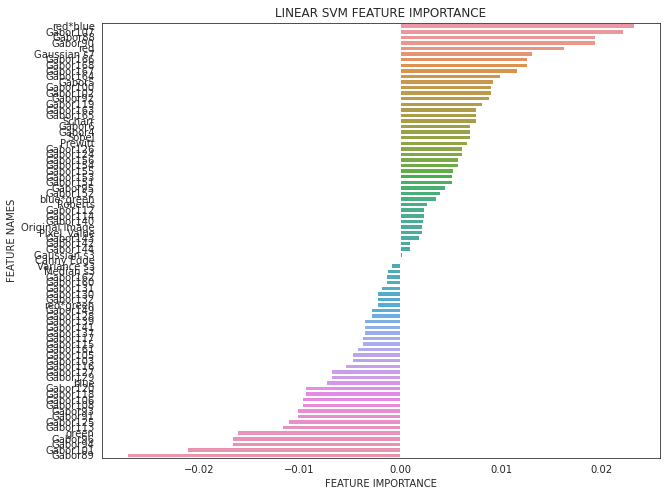

In [ ]:
plot_feature_importance(svm.coef_[0],X.columns,'LINEAR SVM ')
# f_importances(svm.coef_[0], X_train.columns)


In [ ]:
remove_less_significant_features(X,pd.DataFrame(svm.coef_[0]),pd.DataFrame(X.columns))